In [6]:
import pandas as pd
import sqlalchemy as sql
import music21 as m2
import glob
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
server = "thesis.ca6j6heoraog.eu-central-1.rds.amazonaws.com"
engine = sql.create_engine(f"mysql+pymysql://admin:FphvsYQek4@{server}/thesis_db")


In [4]:
con = engine.connect()

In [5]:
query="""
select group_id, max(data_time) experiment_length_secs
from raw_interval_data
where series_type_id=4
group by group_id
"""
df = pd.read_sql_query(query, con)
df

,group_id,experiment_length_secs
0,1001,259.430
1,1003,237.164
2,1004,248.968
3,1005,248.844
4,1006,249.920
5,1007,274.596
6,1008,239.916
7,1009,250.342
8,1010,245.640
9,1011,250.126


In [19]:
midi_files = glob.glob('../data/MIDI-Freestyle/Freestyle_*.mid')
group_number = lambda fname: int(fname.split('_')[1][:4])
file_list = sorted([file for file in midi_files ])
file_list

['../data/MIDI-Freestyle/Freestyle_1001.mid',
 '../data/MIDI-Freestyle/Freestyle_1002.mid',
 '../data/MIDI-Freestyle/Freestyle_1003.mid',
 '../data/MIDI-Freestyle/Freestyle_1004.mid',
 '../data/MIDI-Freestyle/Freestyle_1005.mid',
 '../data/MIDI-Freestyle/Freestyle_1006.mid',
 '../data/MIDI-Freestyle/Freestyle_1007.mid',
 '../data/MIDI-Freestyle/Freestyle_1008.mid',
 '../data/MIDI-Freestyle/Freestyle_1009.mid',
 '../data/MIDI-Freestyle/Freestyle_1010.mid',
 '../data/MIDI-Freestyle/Freestyle_1011.mid',
 '../data/MIDI-Freestyle/Freestyle_1012.mid',
 '../data/MIDI-Freestyle/Freestyle_1013.mid',
 '../data/MIDI-Freestyle/Freestyle_1014.mid',
 '../data/MIDI-Freestyle/Freestyle_1015.mid',
 '../data/MIDI-Freestyle/Freestyle_1016.mid',
 '../data/MIDI-Freestyle/Freestyle_1017.mid',
 '../data/MIDI-Freestyle/Freestyle_1018.mid',
 '../data/MIDI-Freestyle/Freestyle_1019.mid',
 '../data/MIDI-Freestyle/Freestyle_1020.mid',
 '../data/MIDI-Freestyle/Freestyle_1021.mid',
 '../data/MIDI-Freestyle/Freestyle

In [10]:
def get_drumbeat_ticks_for_midi(midi_path):
    mf = m2.midi.MidiFile()
    mf.open(midi_path)
    mf.read()
    mf.close()
    ev = mf.tracks[0].events
    df = pd.DataFrame(data=[e.__dict__ for e in ev])
    df.insert(2,'type_str',df.type.map(lambda t: str(t).split('.')[-1]))
    df.insert(4,'time_abs',df.time.cumsum())

    all_events = {}
    open_events = {}
    for row in df[df.type_str.isin(['NOTE_ON','NOTE_OFF'])].itertuples():
        if row.type_str=='NOTE_ON':
            open_events[row.parameter1]=row.time_abs
        else:
            all_events[row.parameter1]=all_events.get(row.parameter1,[])+[(open_events[row.parameter1], row.time_abs)]


    return all_events

In [20]:
all_events = { group_number(file): get_drumbeat_ticks_for_midi(file) for file in file_list}


In [38]:
group_last_event = {k: max(np.array(v).max() for  v in ev.values()) for k, ev in all_events.items()}
group_first_event = {k: min(np.array(v).min() for  v in ev.values()) for k, ev in all_events.items()}

In [22]:
group_last_event

{1001: 37390,
 1002: 36530,
 1003: 30268,
 1004: 33281,
 1005: 32642,
 1006: 35450,
 1007: 37142,
 1008: 33019,
 1009: 45259,
 1010: 33908,
 1011: 34783,
 1012: 34054,
 1013: 33480,
 1014: 38666,
 1015: 36363,
 1016: 32826,
 1017: 33019,
 1018: 34368,
 1019: 35861,
 1020: 34084,
 1021: 31884,
 1022: 31626,
 1023: 31839,
 1024: 31812,
 1025: 32475,
 1026: 31979,
 1027: 31127,
 1028: 31645,
 1029: 30927,
 1030: 32318,
 1031: 33260,
 1032: 32438,
 1033: 33054,
 1034: 31993,
 1035: 32190,
 1036: 32384,
 1037: 32240,
 1038: 32349,
 1039: 32622,
 1040: 31606,
 1041: 31668,
 1042: 31715,
 1043: 33201,
 1044: 35604,
 1045: 32450,
 1046: 32563,
 1047: 30998,
 1048: 32851,
 1049: 32676,
 1050: 33827,
 1051: 32379}

In [41]:
df['group_last_event'] = df.apply(lambda r: group_last_event[int(r[0])], axis=1)
df['group_first_event'] = df.apply(lambda r: group_first_event[int(r[0])], axis=1)
df['duration'] = df['group_last_event']- df['group_first_event']
df['group_last_event_time_guess']=df['group_last_event']/96
df

,group_id,experiment_length_secs,group_last_event,group_last_event_time_guess,group_first_event,duration
0,1001,259.430,37390,389.479167,2974,34416
1,1003,237.164,30268,315.291667,348,29920
2,1004,248.968,33281,346.677083,283,32998
3,1005,248.844,32642,340.020833,254,32388
4,1006,249.920,35450,369.270833,1266,34184
5,1007,274.596,37142,386.895833,1392,35750
6,1008,239.916,33019,343.947917,995,32024
7,1009,250.342,45259,471.447917,1010,44249
8,1010,245.640,33908,353.208333,1321,32587
9,1011,250.126,34783,362.322917,338,34445


In [27]:
df.scatterplot(x='experiment_length_secs', y='group_last_event')

AttributeError: 'DataFrame' object has no attribute 'scatterplot'

<AxesSubplot:xlabel='experiment_length_secs', ylabel='duration'>

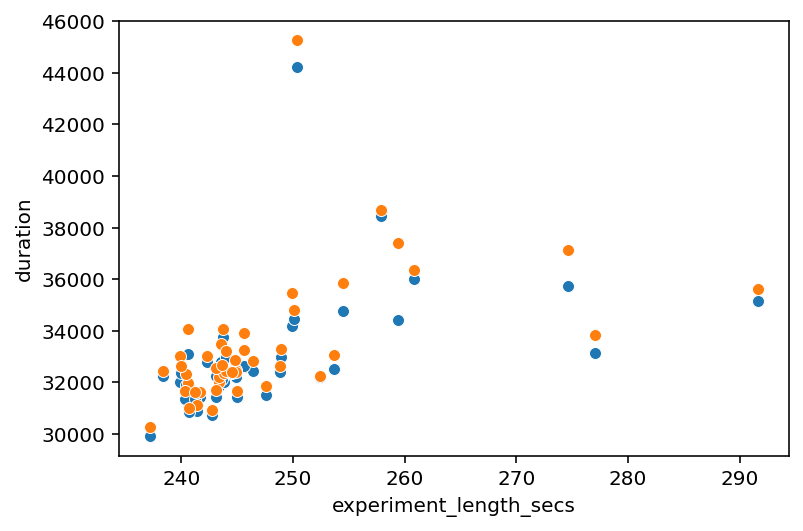

In [45]:
sns.scatterplot(data=df, x='experiment_length_secs', y='duration')
sns.scatterplot(data=df, x='experiment_length_secs', y='group_last_event')
#plt.plot([240, 290], [240,290])

In [32]:
[all_events[1003][i][-1] for i in [43,45,48]]

[(30192, 30205), (30171, 30183), (30255, 30268)]